# Homework - Outlier detection

***Agata Makarewicz***

*Week 12 & 13*

### 0. Introduction

Task: detecting outliers in Cardiotocography dataset

Dataset description:
* https://archive.ics.uci.edu/ml/datasets/cardiotocography
* https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/semantic/Cardiotocography/Cardiotocography_22.html

In [1]:
# loading packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

import copy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.spatial.distance import pdist, mahalanobis, squareform
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, precision_score, recall_score, confusion_matrix, f1_score, fbeta_score
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = None

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [2]:
data = pd.read_csv('Cardiotocography.csv')

In [3]:
data_x = data.drop('outlier', axis=1)
target = data['outlier']
features = list(data_x.columns)

### I. EDA

Attribute information:

* id - patient id
* LB - FHR baseline (beats per minute)
* AC - # of accelerations per second
* FM - # of fetal movements per second
* UC - # of uterine contractions per second
* DL - # of light decelerations per second
* DS - # of severe decelerations per second
* DP - # of prolongued decelerations per second
* ASTV - percentage of time with abnormal short term variability
* MSTV - mean value of short term variability
* ALTV - percentage of time with abnormal long term variability
* MLTV - mean value of long term variability
* Width - width of FHR histogram
* Min - minimum of FHR histogram
* Max - Maximum of FHR histogram
* Nmax - # of histogram peaks
* Nzeros - # of histogram zeros
* Mode - histogram mode
* Mean - histogram mean
* Median - histogram median
* Variance - histogram variance
* Tendency - histogram tendency
<br><br>
* **outlier** - whether outlier or not

We can observe that half of our variables is related to FHR histogram properties, one third contain count of particular movements/occurences per second/minute, and the rest - some other statistics (mean & percentages).

In [4]:
data.head()

id        LB        AC        FM        UC      ASTV      MSTV  \
0  1881.0  0.592593  0.000000  0.000000  0.294118  0.633803  0.338235   
1   421.0  0.574074  0.038462  0.000000  0.000000  0.816901  0.029412   
2    92.0  0.777778  0.000000  0.000000  0.000000  0.774648  0.029412   
3  1767.0  0.259259  0.000000  0.000000  0.294118  0.704225  0.191176   
4  1880.0  0.592593  0.000000  0.001773  0.294118  0.633803  0.352941   

       ALTV      MLTV        DL   DS        DP     Width       Min       Max  \
0  0.000000  0.013807  0.500000  0.0  0.000000  0.595376  0.045872  0.336207   
1  0.527473  0.092702  0.000000  0.0  0.000000  0.364162  0.770642  0.672414   
2  0.736264  0.096647  0.000000  0.0  0.000000  0.069364  0.816514  0.275862   
3  0.000000  0.183432  0.428571  0.0  0.333333  0.473988  0.174312  0.275862   
4  0.000000  0.013807  0.428571  0.0  0.333333  0.595376  0.045872  0.336207   

       Nmax  Nzeros      Mode      Mean    Median  Variance  Tendency outlier  
0  0.333333     0.1  0.485149  0.247423  0.284091  0.638418       1.0  b'yes'  
1  0.166667     0.0  0.534653  0.587629  0.511364  0.016949       0.0  b'yes'  
2  0.222222     0.0  0.633663  0.659794  0.602273  0.000000       1.0  b'yes'  
3  0.222222     0.1  0.000000  0.164948  0.000000  0.361582       0.0  b'yes'  
4  0.333333     0.1  0.485149  0.226804  0.272727  0.683616       1.0  b'yes'

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        16880 non-null  float64
 1   LB        16880 non-null  float64
 2   AC        16880 non-null  float64
 3   FM        16880 non-null  float64
 4   UC        16880 non-null  float64
 5   ASTV      16880 non-null  float64
 6   MSTV      16880 non-null  float64
 7   ALTV      16880 non-null  float64
 8   MLTV      16880 non-null  float64
 9   DL        16880 non-null  float64
 10  DS        16880 non-null  float64
 11  DP        16880 non-null  float64
 12  Width     16880 non-null  float64
 13  Min       16880 non-null  float64
 14  Max       16880 non-null  float64
 15  Nmax      16880 non-null  float64
 16  Nzeros    16880 non-null  float64
 17  Mode      16880 non-null  float64
 18  Mean      16880 non-null  float64
 19  Median    16880 non-null  float64
 20  Variance  16880 non-null  fl

All of our features are numerical (excluding target variable), and we have no missing values in our data.

In [6]:
data.describe().T

count         mean         std  min         25%          50%  \
id        16880.0  1123.872156  593.610901  1.0  641.000000  1150.500000   
LB        16880.0     0.483186    0.175738  0.0    0.351852     0.481481   
AC        16880.0     0.129270    0.143077  0.0    0.000000     0.076923   
FM        16880.0     0.011411    0.060514  0.0    0.000000     0.000000   
UC        16880.0     0.226668    0.156665  0.0    0.117647     0.235294   
ASTV      16880.0     0.425672    0.216970  0.0    0.236111     0.408451   
MSTV      16880.0     0.179521    0.121198  0.0    0.088235     0.161765   
ALTV      16880.0     0.064739    0.146732  0.0    0.000000     0.000000   
MLTV      16880.0     0.170819    0.114551  0.0    0.094675     0.155819   
DL        16880.0     0.113227    0.171935  0.0    0.000000     0.000000   
DS        16880.0     0.000770    0.027742  0.0    0.000000     0.000000   
DP        16880.0     0.017417    0.084956  0.0    0.000000     0.000000   
Width     16880.0     0.391083    0.214992  0.0    0.204678     0.377907   
Min       16880.0     0.379411    0.252147  0.0    0.155963     0.376147   
Max       16880.0     0.365604    0.153285  0.0    0.258621     0.353448   
Nmax      16880.0     0.230579    0.159211  0.0    0.111111     0.222222   
Nzeros    16880.0     0.033365    0.069209  0.0    0.000000     0.000000   
Mode      16880.0     0.563887    0.128429  0.0    0.482143     0.567797   
Mean      16880.0     0.525497    0.136375  0.0    0.431193     0.525773   
Median    16880.0     0.475086    0.146790  0.0    0.373494     0.478261   
Variance  16880.0     0.090984    0.119737  0.0    0.015385     0.045198   
Tendency  16880.0     0.670794    0.295171  0.0    0.500000     0.500000   

                  75%     max  
id        1619.000000  2126.0  
LB           0.592593     1.0  
AC           0.192308     1.0  
FM           0.003546     1.0  
UC           0.304348     1.0  
ASTV         0.608108     1.0  
MSTV         0.220588     1.0  
ALTV         0.050633     1.0  
MLTV         0.226824     1.0  
DL           0.214286     1.0  
DS           0.000000     1.0  
DP           0.000000     1.0  
Width        0.549133     1.0  
Min          0.596330     1.0  
Max          0.456897     1.0  
Nmax         0.333333     1.0  
Nzeros       0.000000     1.0  
Mode         0.650000     1.0  
Mean         0.621053     1.0  
Median       0.576087     1.0  
Variance     0.122677     1.0  
Tendency     1.000000     1.0

In [7]:
data.Tendency.value_counts()

0.5    9028
1.0    6809
0.0    1043
Name: Tendency, dtype: int64

In [8]:
data.Nzeros.value_counts()

0.0    12704
0.1     3054
0.2      918
0.3      161
0.5       20
0.4       11
1.0       10
0.7        1
0.8        1
Name: Nzeros, dtype: int64

From the descriptive statistics we can also see that all of our features apart from id are from the range [0,1]

In [10]:
data.duplicated().value_counts() # checking whether duplicated records are present

False    16880
dtype: int64

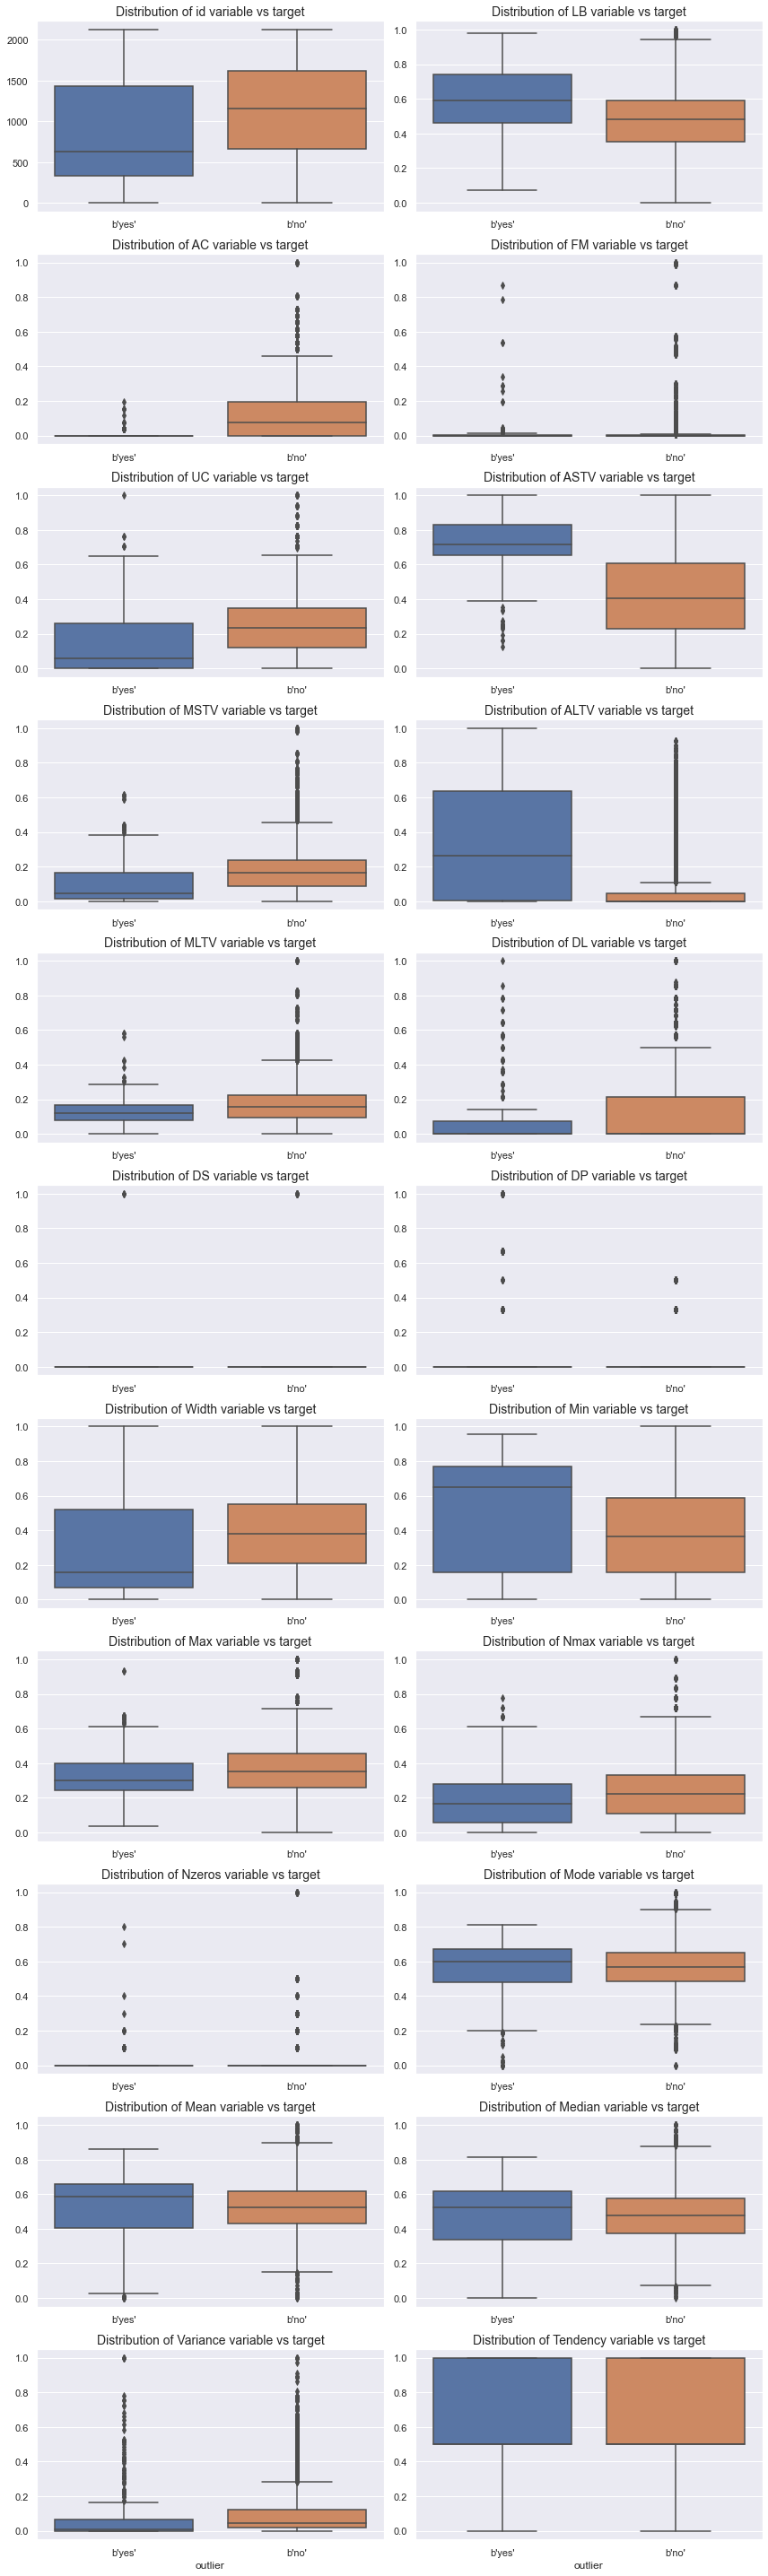

In [11]:
# boxplots
fig, axes = plt.subplots(11,2,figsize=(12, 40))
for i in range(len(features)):
    plot = sns.boxplot(y = features[i], x='outlier', data=data, ax=axes[i//2,i%2])
    plot.set_title('Distribution of '+features[i]+ ' variable vs target', size=14)
    plot.set(ylabel='', xlabel='')
    if i in [20,21] : plot.set(xlabel='outlier')
plt.tight_layout()

Taking a look at our features' distribution due to target value we can easily spot outliers in many of them. In case of `FM`, `DS`, `DP`, `Nzeros` variables, we cannot even see the actual "box" of our boxplot; on the other hand, in such features as `AC`, `ALTV` or `ASTV` we can observe big differences in distribution depending on target value, so we expect them to be important to our prediction.

Let's now take a look at relationships between our variables, but in two groups - those related to histogram, and the rest, given we have 22 features in total (excluding id in this analysis).

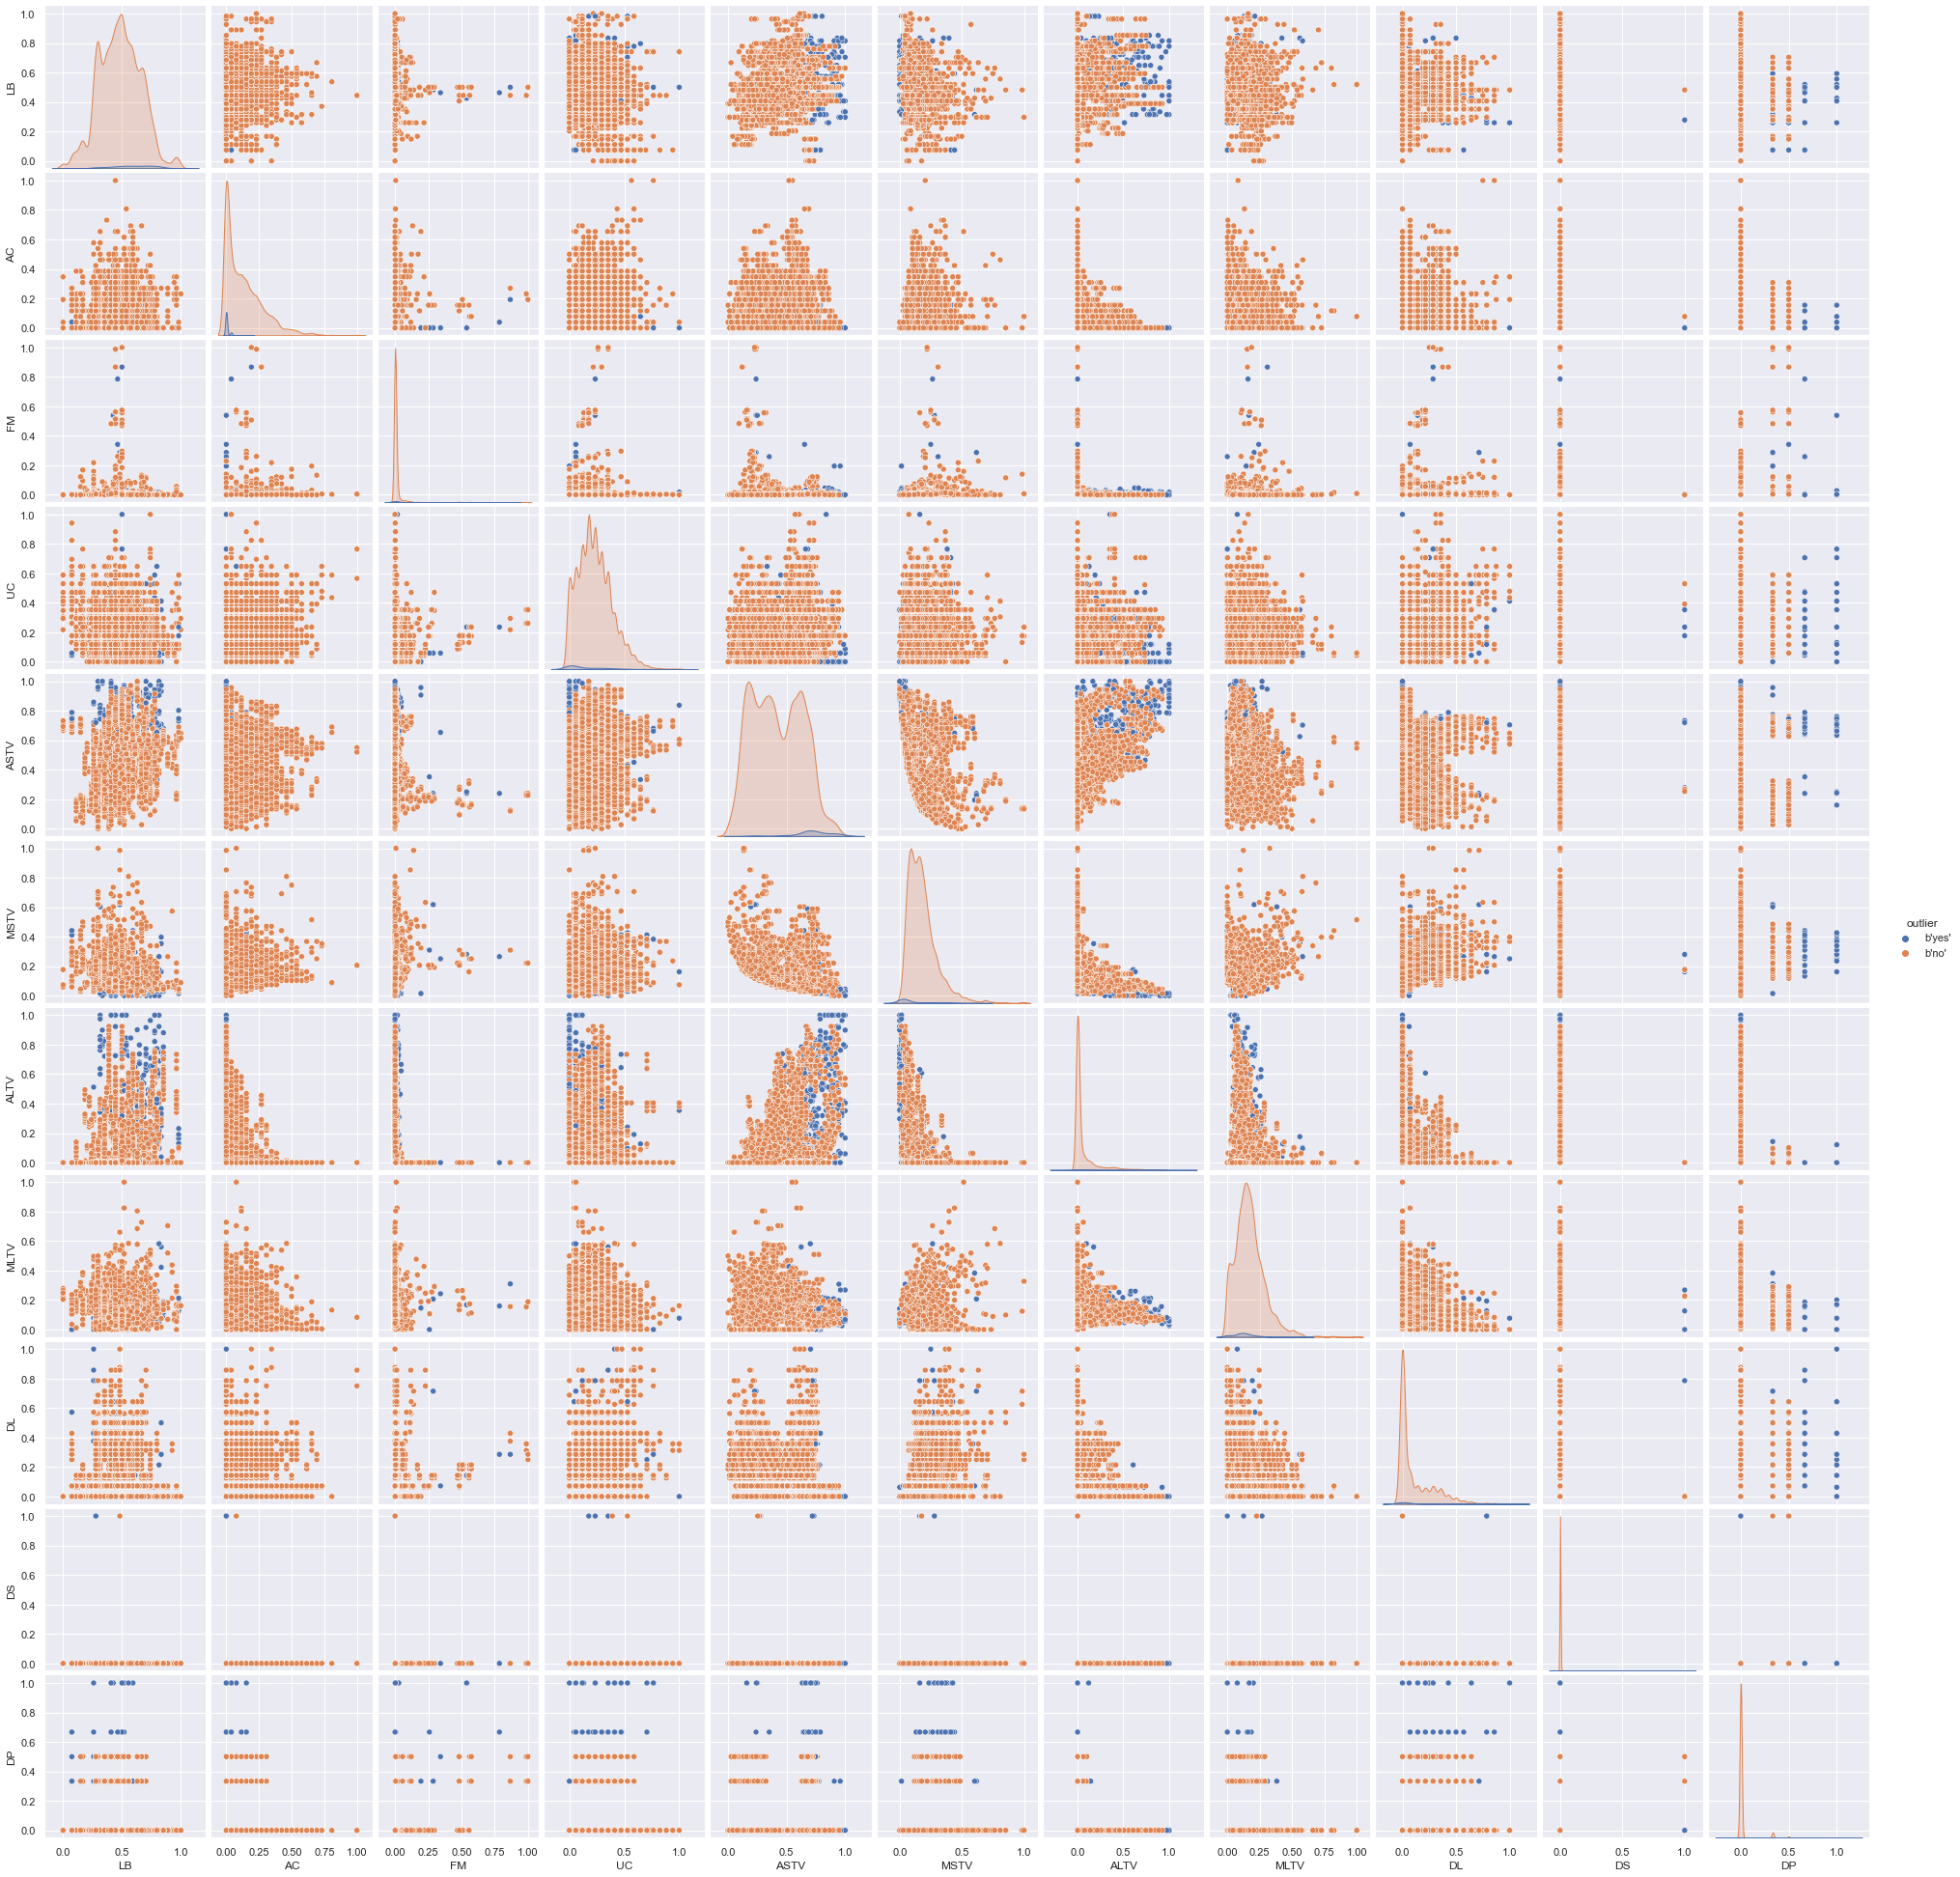

In [31]:
sns.pairplot(data.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,22]], hue='outlier')

In [32]:
data_x.DS.value_counts()

0.0    16867
1.0       13
Name: DS, dtype: int64

We can observe that mostly big values of `DS` and `DP` are classified as outliers. There is also an interesting relationship between `MSTV` and `ASTV` variables. There are also some clearly visible outliers in `FM` variable.

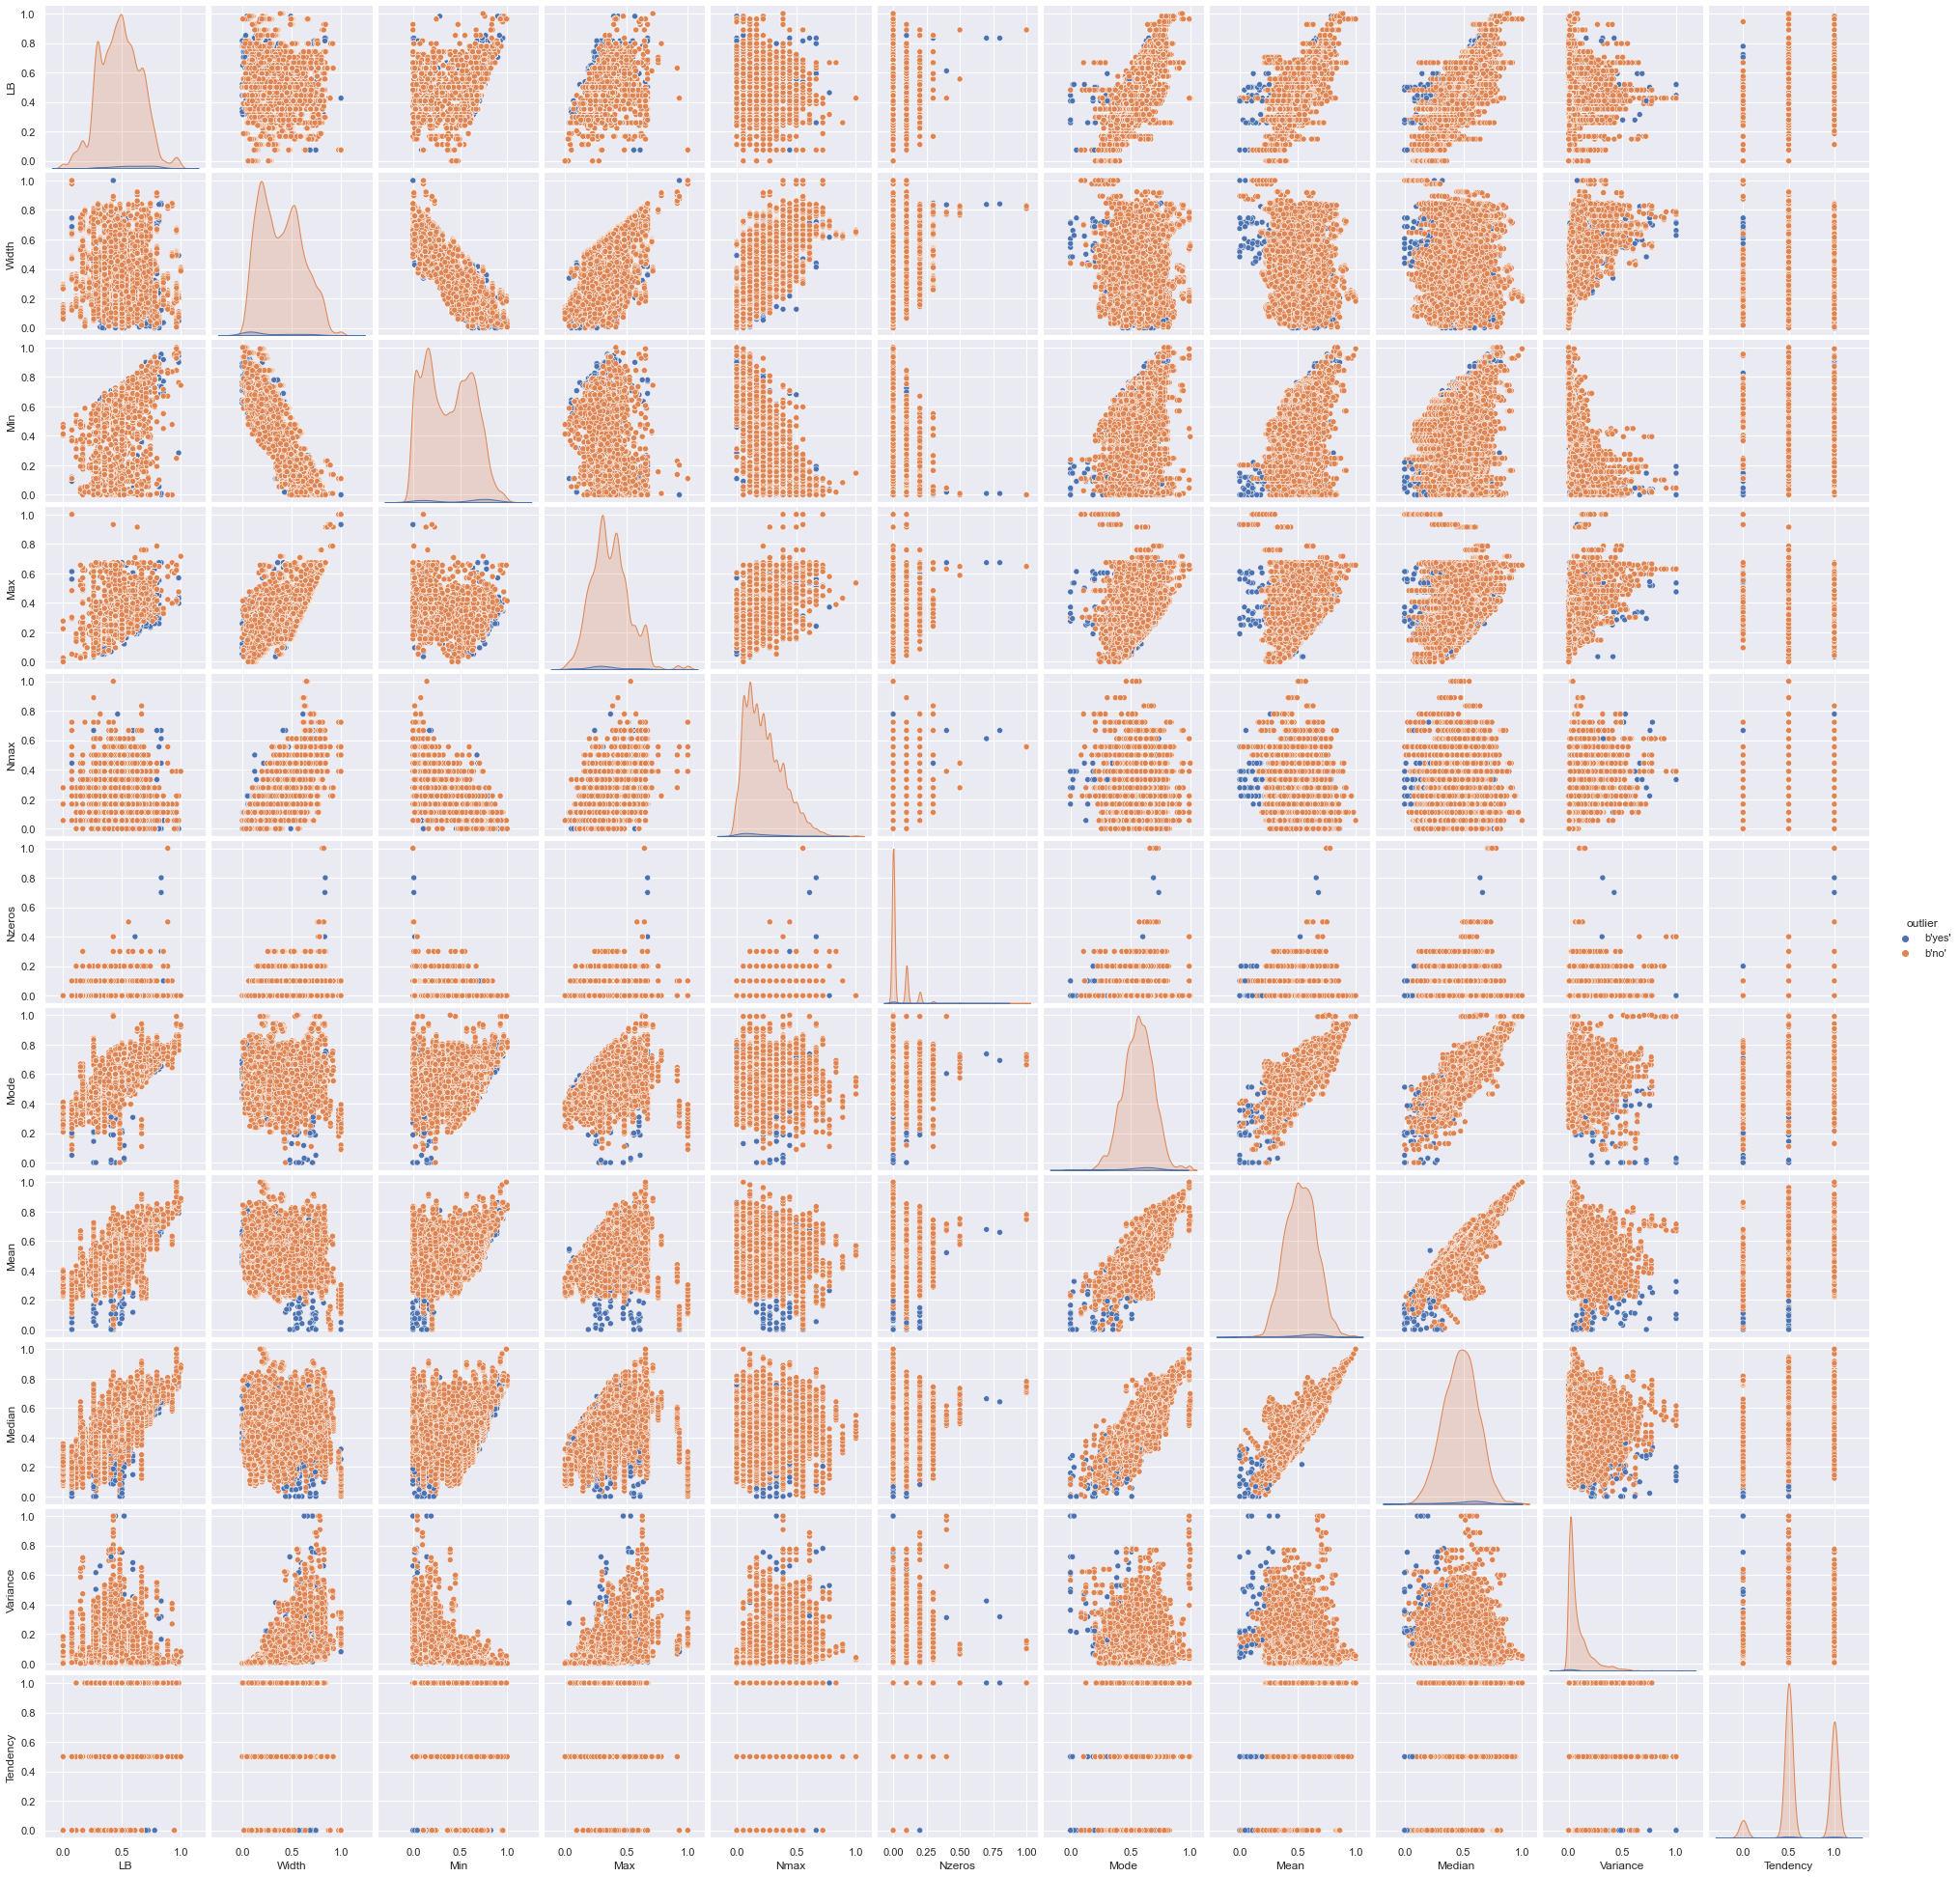

In [33]:
sns.pairplot(data.iloc[:,[1,12,13,14,15,16,17,18,19,20,21,22]], hue='outlier')

Here we can observe almost linear relationship between `Mean`, `Mode` and `Median` features, which is natural; there's also reversed linear relation between `Min` and `Width` variables.

#### Correlated features

<AxesSubplot:>

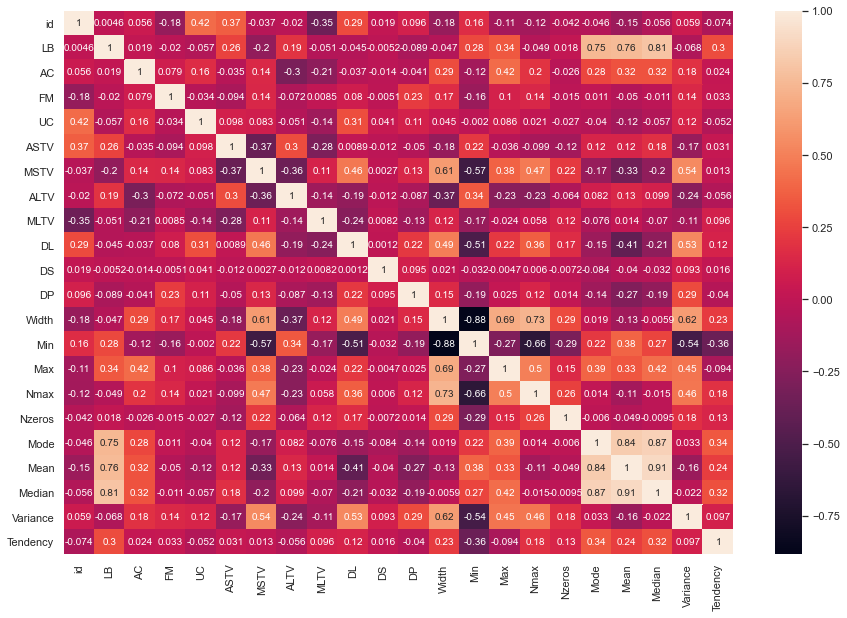

In [34]:
corr = data.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True)

As previously seen on the pairplot, `Mean`, `Mode` and `Median` variables are highly correlated, so some of them need to be dropped. What's more, they're also highly correlated with `LB`. Another correlated pair spotted before are `Min` and `Width`; this time negatively.

#### Target analysis

In [50]:
data.outlier.value_counts()

0    16550
1      330
Name: outlier, dtype: int64

We can see that our target is highly imbalanced - only 2% of our data is classified as outliers.

### Data preprocessing

In [4]:
# encoding target as binary
target[target=="b'no'"] = 0
target[target=="b'yes'"] = 1
target = target.astype('int')

In [5]:
# dropping features identified as correlated during EDA 
data_x_dropped = data_x.drop(['Width','Mode','Mean'], axis=1)

#### Nonlinear transformations

Let's try to modify some of the existing features in order to make their distribution more similar to normal one.

Optimal lambda value: 0.15788864294161334
Optimal lambda value: 0.4710364765211962
Optimal lambda value: 0.20305259273228424
Optimal lambda value: 0.35423908537988913


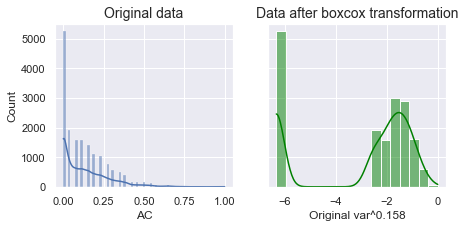

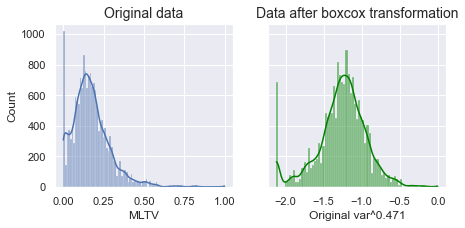

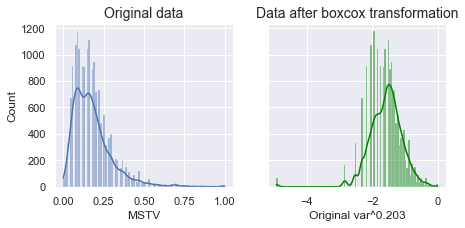

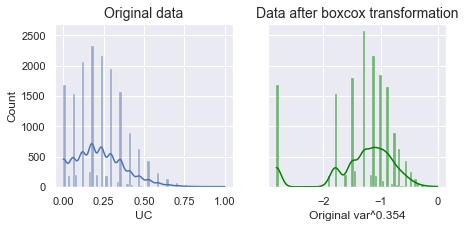

In [14]:
# AC, MLTV, MSTV, UC
original_vars = [data.AC, data.MLTV, data.MSTV, data.UC]
original_vars_plus = [data.AC[data.AC>0], data.MLTV[data.MLTV>0], data.MSTV[data.MSTV>0], data.UC[data.UC>0]]

for i in range(len(original_vars)):
    fitted_data, fitted_lambda = boxcox(original_vars_plus[i]) 
    new_data = copy.copy(original_vars[i])
    new_data[original_vars[i]>0] = fitted_data
    new_data[original_vars[i]==0] = -1/fitted_lambda
    fig, ax = plt.subplots(1, 2, sharey = True, figsize=(7,3)) 
    sns.histplot(original_vars[i], kde = True, ax = ax[0]).set_title('Original data', size=14)
    sns.histplot(new_data,  kde = True, color ="green", ax = ax[1]).set_title('Data after boxcox transformation', size=14) 
    ax[1].set(xlabel = 'Original var^'+str(round(fitted_lambda, 3)))
    print(f"Optimal lambda value: {fitted_lambda}") 

`MLTV` transformation looks quite good, and `MSTV` is also a bit better, so we will use them.

In [6]:
# boxcox
data_x_dropped.MLTV = data_x_dropped.MLTV**0.4710364765211962
data_x_dropped.MSTV = data_x_dropped.MSTV**0.20305259273228424

In [7]:
# standarization 
std_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('variance_trsh', VarianceThreshold(threshold=0.1))
])

In [8]:
# pca for data visualisation 
pca = PCA(n_components=2)
data_pca = pca.fit_transform(std_pipe.fit_transform(data_x))

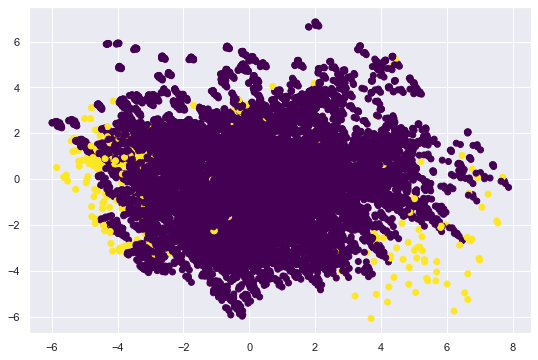

In [9]:
plt.scatter(data_pca[:,0], data_pca[:,1], c=target, cmap='viridis')

### Mahalanobis rule

In [19]:
mean_vector = pd.DataFrame(std_pipe.fit_transform(data_x_dropped)).mean(axis=0)

bias_distance = pd.DataFrame(std_pipe.fit_transform(data_x_dropped)).apply(lambda row:
                             mahalanobis(mean_vector, row, VI=np.linalg.inv(np.cov(pd.DataFrame(std_pipe.fit_transform(data_x_dropped)).T))), axis=1)

In [20]:
predictions = np.ones(data_x.shape[0])
predictions[bias_distance > 2] = -1

In [21]:
pd.DataFrame(predictions).value_counts()

-1.0    16641
 1.0      239
dtype: int64

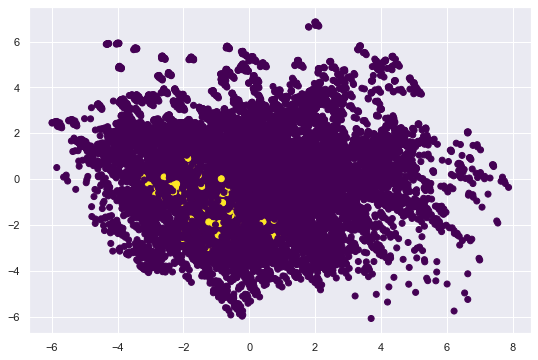

In [22]:
plt.scatter(data_pca[:,0], data_pca[:,1], c=predictions, cmap='viridis')

We can see that this method of outlier detection doesn't work really well on our dataset.

### Metrics

Due to imbalance of our data, we should consider appropriate metrics to evaluate our models. Let's go with following:

* Precision - we want to minimize False Positives a
* Recall - we don't want to miss any positives 
* F1 and FBeta score - the harmonic mean of precision and recall
* Micro/weighted Average F1_Score - takes number of instances in each class into account, therefore better for imbalanced data
* Confusion matrix (normalized) - normalized due to imbalance

All the metrics above will be proper for our data, as we can calculate them for each class and take imbalance into account.

### Supervised models

In [33]:
# metrics for supervised model evaluations
# choice due to target imbalance 
def evaluate_metrics(true, pred):
    Precision = precision_score(true, pred, average = None)
    Recall = recall_score(true, pred, average = None)
    F1_score = f1_score(true, pred, average = None)
    F_beta = fbeta_score(true, pred, average = None,beta=2)
    
    results = pd.DataFrame(np.array([Precision,Recall,F1_score,F_beta]))
    results.index = ['Precision','Recall','F1_score','F_beta']
    results.columns = list(np.unique(target))
    f1 = f1_score(true, pred, average='weighted')
    return results, f1

In [34]:
def plot_confusion(classifier, X, y, name):
    plot_confusion_matrix(classifier, X, y, normalize='true', cmap=plt.cm.Blues)
    plt.grid(False)
    plt.title(name + ' confusion matrix', size=16)
    plt.xlabel = 'Predicted label'
    plt.ylabel = 'True label'

#### Train-test split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(data_x_dropped, target, test_size=0.25, stratify=target)

In [61]:
y_train.value_counts()

0    12413
1      247
Name: outlier, dtype: int64

In [64]:
X_train = pd.DataFrame(std_pipe.fit_transform(X_train))
X_test = pd.DataFrame(std_pipe.transform(X_test))

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

X_train.columns = data_x_dropped.columns
X_test.columns = data_x_dropped.columns

In [66]:
# oversampling in order to balance our target
oversample = SMOTE(random_state = 123)           
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train) 

In [67]:
y_train_over.value_counts()

0    12413
1    12413
Name: outlier, dtype: int64

#### SVM

In [94]:
svm = SVC()
svm.fit(X_train,y_train)
pred = svm.predict(X_test)

In [95]:
results, f1 = evaluate_metrics(y_test,pred)
print(f1) # weighted f1 score
results

0.9915262432853041


0         1
Precision  0.992324  1.000000
Recall     1.000000  0.614458
F1_score   0.996147  0.761194
F_beta     0.998455  0.665796

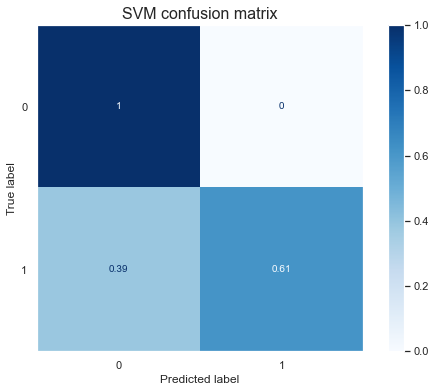

In [96]:
plot_confusion(svm, X_test, y_test, 'SVM')

In [91]:
svm = SVC()
svm.fit(X_train_over,y_train_over)
pred = svm.predict(X_test)

In [92]:
results, f1 = evaluate_metrics(y_test,pred)
print(f1) # weighted f1 score
results

0.9755901367845097


0         1
Precision  0.998756  0.386139
Recall     0.970027  0.939759
F1_score   0.984181  0.547368
F_beta     0.975639  0.730337

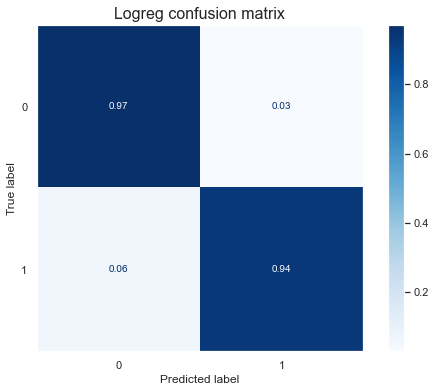

In [93]:
plot_confusion(svm, X_test, y_test, 'SVM oversampling')

Oversampling improved our result greatly - almost all observations are properly classified; but even without it SVM gives us a pretty good result, given it's a default model without tuning.

#### Logistic regression

In [75]:
clf_reg = LogisticRegression().fit(X_train, y_train)
pred = clf_reg.predict(X_test)

In [76]:
results, f1 = evaluate_metrics(y_test,pred)
print(f1) # weighted f1 score
results

0.98940780410663


0         1
Precision  0.991365  0.921569
Recall     0.999033  0.566265
F1_score   0.995184  0.701493
F_beta     0.997490  0.613577

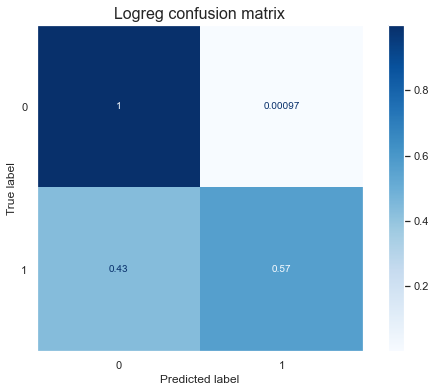

In [83]:
plot_confusion(clf_reg, X_test, y_test, 'Logreg')

In [80]:
clf_reg_over = LogisticRegression().fit(X_train_over, y_train_over)
pred = clf_reg_over.predict(X_test)

In [81]:
results, f1 = evaluate_metrics(y_test,pred)
print(f1) # weighted f1 score
results

0.9356360298421748


0         1
Precision  0.997337  0.156989
Recall     0.905245  0.879518
F1_score   0.949062  0.266423
F_beta     0.922277  0.457967

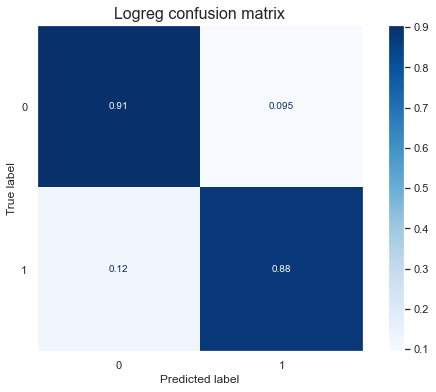

In [82]:
plot_confusion(clf_reg_over, X_test, y_test, 'Logreg oversampling')

In case of logistic regression we also get far better classification than without it, however, it still performs a bit worse than SVM.

#### KNN

In [84]:
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)
pred = neigh.predict(X_test)

In [86]:
results, f1 = evaluate_metrics(y_test,pred)
print(f1) # weighted f1 score
results

0.9912254886650526


0        1
Precision  0.992086  1.00000
Recall     1.000000  0.60241
F1_score   0.996027  0.75188
F_beta     0.998407  0.65445

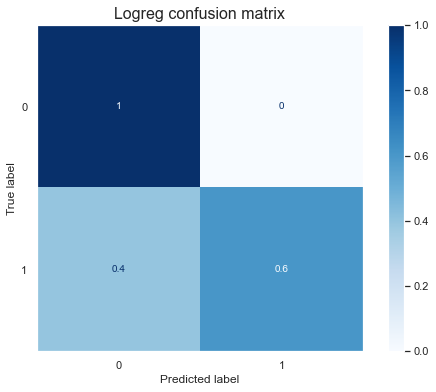

In [87]:
plot_confusion(neigh, X_test, y_test, 'KNN')

In [88]:
neigh = KNeighborsClassifier()
neigh.fit(X_train_over, y_train_over)
pred = neigh.predict(X_test)

In [89]:
results, f1 = evaluate_metrics(y_test,pred)
print(f1) # weighted f1 score
results

0.9968725265973557


0         1
Precision  0.997827  0.948718
Recall     0.999033  0.891566
F1_score   0.998430  0.919255
F_beta     0.998792  0.902439

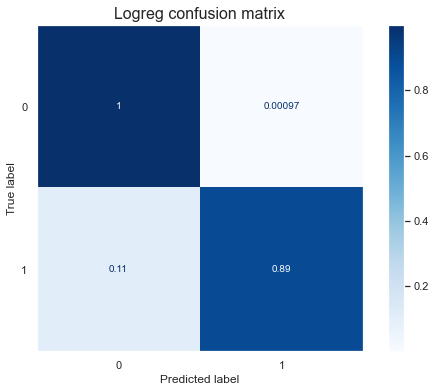

In [90]:
plot_confusion(neigh, X_test, y_test, 'KNN oversampling')

For normal KNN we get similar results as for logistic regression; it performs a bit better when it comes to oversampling (we observe greater improvement).

### Unsupervised models

In [10]:
target_2 = copy.copy(target)

target_2[target_2 == 1] = -1
target_2[target_2 == 0] = 1

In [11]:
data_x_2 = pd.DataFrame(std_pipe.fit_transform(data_x_dropped))
target_2 = pd.Series(target_2)
data_x_2.columns = data_x_dropped.columns

#### One-Class SVM

In [59]:
codense = pdist(data_x_2, metric='mahalanobis', VI=np.linalg.inv(np.cov(data_x_2.T)))
distance = squareform(codense)

In [61]:
one_svm = OneClassSVM()
svm_predictions = one_svm.fit_predict(distance)

In [65]:
pd.DataFrame(svm_predictions).value_counts()

-1    8441
 1    8439
dtype: int64

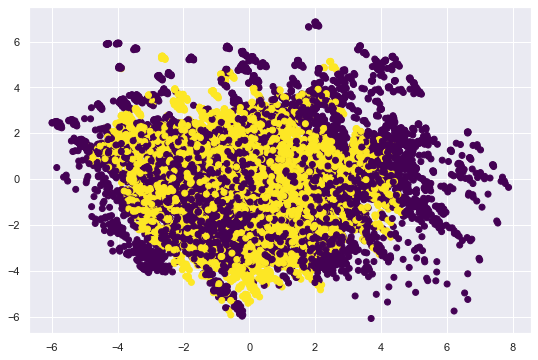

In [63]:
plt.scatter(data_pca[:,0], data_pca[:,1], c=svm_predictions, cmap='viridis')

Default OneClassSVM didn't manage to detect our outliers, so let's try to optimize its parameters to achieve better classification.

In [14]:
grid = {'kernel': ["poly", "rbf", "sigmoid"],
        'gamma' : np.logspace(-9, 3, 13),
        'nu' : np.linspace(0.01, 0.99, 99)}

In [27]:
svm_estimator = RandomizedSearchCV(OneClassSVM(), 
                                     grid,
                                     n_iter = 30,
                                     scoring='f1_micro', 
                                     refit=True,
                                     cv = StratifiedKFold(n_splits=3))
svm_estimator.fit(data_x_2, target_2)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=OneClassSVM(), n_iter=30,
                   param_distributions={'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'kernel': ['poly', 'rbf', 'sigmoid'],
                                        'nu': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12,...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.9

In [28]:
svm_estimator.best_params_

{'nu': 0.04, 'kernel': 'rbf', 'gamma': 0.001}

In [29]:
svm_predictions_2 = svm_estimator.predict(data_x_2)

In [30]:
pd.DataFrame(svm_predictions_2).value_counts()

 1    16209
-1      671
dtype: int64

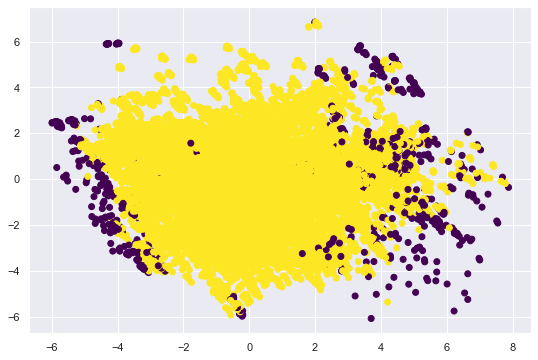

In [31]:
plt.scatter(data_pca[:,0], data_pca[:,1], c=svm_predictions_2, cmap='viridis')

In [36]:
results, f1 = evaluate_metrics(target_2,svm_predictions_2)
print(f1) # weighted f1 score
results.columns = ['-1','1']
results

0.9640430018043767


-1         1
Precision  0.204173  0.988093
Recall     0.415152  0.967734
F1_score   0.273726  0.977808
F_beta     0.344048  0.971739

With optimized parameters OneClassSVM managed to detect some part of the outliers, however computing time is a big drawback in case of this algoritm, so let's try a faster one.

#### Isolation Forest

In [32]:
iso_forest = IsolationForest()
iso_predictions = iso_forest.fit_predict(data_x_2)

In [33]:
pd.DataFrame(iso_predictions).value_counts()

 1    15396
-1     1484
dtype: int64

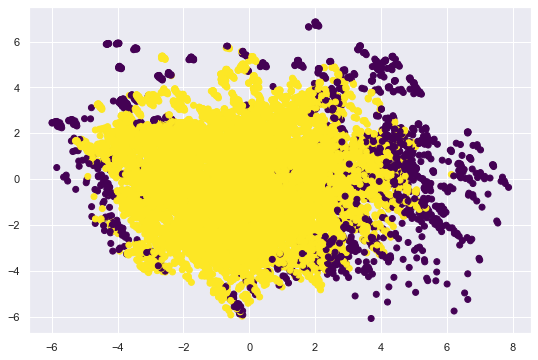

In [34]:
plt.scatter(data_pca[:,0], data_pca[:,1], c=iso_predictions, cmap='viridis')

Isolation Forest without tuning gives us 4x too many outliers; let's try to optimize hyperparameters to get better result.

In [41]:
# hyperparameters tuning
param_grid = {'n_estimators': list(range(100, 500, 100)), 
              'max_samples': list(range(100, 500, 100)), 
              'contamination': [0.1, 0.2, 0.3], 
              'max_features': [5,10,15], 
              'bootstrap': [True, False]}

In [43]:
iso_estimator = GridSearchCV(iso_forest, 
                             param_grid,
                             scoring='f1_micro', 
                             refit=True,
                             cv = StratifiedKFold(n_splits=3),
                             verbose=2)
iso_estimator.fit(data_x_2, target_2) 

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=200; total time=   2.4s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=200; total time=   2.4s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=200; total time=   2.5s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=300; total time=   4.0s
[CV] END bootstrap=True, contamination=0.1, max_features=5, max_samples=100, n_estimators=300; total time=   4.4s
[CV] END bootstrap=True, 

[CV] END bootstrap=True, contamination=0.1, max_features=10, max_samples=300, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, contamination=0.1, max_features=10, max_samples=300, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, contamination=0.1, max_features=10, max_samples=300, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, contamination=0.1, max_features=10, max_samples=300, n_estimators=200; total time=   2.9s
[CV] END bootstrap=True, contamination=0.1, max_features=10, max_samples=300, n_estimators=200; total time=   3.0s
[CV] END bootstrap=True, contamination=0.1, max_features=10, max_samples=300, n_estimators=200; total time=   3.1s
[CV] END bootstrap=True, contamination=0.1, max_features=10, max_samples=300, n_estimators=300; total time=   5.0s
[CV] END bootstrap=True, contamination=0.1, max_features=10, max_samples=300, n_estimators=300; total time=   5.1s
[CV] END bootstrap=True, contamination=0.1, max_features=10, max_samples=300, n_

[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=200; total time=   2.4s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=200; total time=   2.4s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=200; total time=   2.5s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=300; total time=   3.7s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimators=300; total time=   3.6s
[CV] END bootstrap=True, contamination=0.2, max_features=5, max_samples=100, n_estimator

[CV] END bootstrap=True, contamination=0.2, max_features=10, max_samples=300, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, contamination=0.2, max_features=10, max_samples=300, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, contamination=0.2, max_features=10, max_samples=300, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, contamination=0.2, max_features=10, max_samples=300, n_estimators=200; total time=   3.1s
[CV] END bootstrap=True, contamination=0.2, max_features=10, max_samples=300, n_estimators=200; total time=   3.1s
[CV] END bootstrap=True, contamination=0.2, max_features=10, max_samples=300, n_estimators=200; total time=   3.1s
[CV] END bootstrap=True, contamination=0.2, max_features=10, max_samples=300, n_estimators=300; total time=   4.8s
[CV] END bootstrap=True, contamination=0.2, max_features=10, max_samples=300, n_estimators=300; total time=   4.8s
[CV] END bootstrap=True, contamination=0.2, max_features=10, max_samples=300, n_

[CV] END bootstrap=True, contamination=0.3, max_features=5, max_samples=100, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, contamination=0.3, max_features=5, max_samples=100, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, contamination=0.3, max_features=5, max_samples=100, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, contamination=0.3, max_features=5, max_samples=100, n_estimators=200; total time=   2.4s
[CV] END bootstrap=True, contamination=0.3, max_features=5, max_samples=100, n_estimators=200; total time=   2.5s
[CV] END bootstrap=True, contamination=0.3, max_features=5, max_samples=100, n_estimators=200; total time=   2.7s
[CV] END bootstrap=True, contamination=0.3, max_features=5, max_samples=100, n_estimators=300; total time=   3.8s
[CV] END bootstrap=True, contamination=0.3, max_features=5, max_samples=100, n_estimators=300; total time=   3.8s
[CV] END bootstrap=True, contamination=0.3, max_features=5, max_samples=100, n_estimator

[CV] END bootstrap=True, contamination=0.3, max_features=10, max_samples=300, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, contamination=0.3, max_features=10, max_samples=300, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, contamination=0.3, max_features=10, max_samples=300, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, contamination=0.3, max_features=10, max_samples=300, n_estimators=200; total time=   3.4s
[CV] END bootstrap=True, contamination=0.3, max_features=10, max_samples=300, n_estimators=200; total time=   3.1s
[CV] END bootstrap=True, contamination=0.3, max_features=10, max_samples=300, n_estimators=200; total time=   3.0s
[CV] END bootstrap=True, contamination=0.3, max_features=10, max_samples=300, n_estimators=300; total time=   4.8s
[CV] END bootstrap=True, contamination=0.3, max_features=10, max_samples=300, n_estimators=300; total time=   4.4s
[CV] END bootstrap=True, contamination=0.3, max_features=10, max_samples=300, n_

[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=100; total time=   2.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=100; total time=   1.1s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=200; total time=   2.9s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=200; total time=   3.0s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=200; total time=   2.8s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=300; total time=   3.9s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_estimators=300; total time=   3.8s
[CV] END bootstrap=False, contamination=0.1, max_features=5, max_samples=100, n_

[CV] END bootstrap=False, contamination=0.1, max_features=10, max_samples=300, n_estimators=100; total time=   2.0s
[CV] END bootstrap=False, contamination=0.1, max_features=10, max_samples=300, n_estimators=100; total time=   2.1s
[CV] END bootstrap=False, contamination=0.1, max_features=10, max_samples=300, n_estimators=100; total time=   2.3s
[CV] END bootstrap=False, contamination=0.1, max_features=10, max_samples=300, n_estimators=200; total time=   3.4s
[CV] END bootstrap=False, contamination=0.1, max_features=10, max_samples=300, n_estimators=200; total time=   3.3s
[CV] END bootstrap=False, contamination=0.1, max_features=10, max_samples=300, n_estimators=200; total time=   3.3s
[CV] END bootstrap=False, contamination=0.1, max_features=10, max_samples=300, n_estimators=300; total time=   5.6s
[CV] END bootstrap=False, contamination=0.1, max_features=10, max_samples=300, n_estimators=300; total time=   6.5s
[CV] END bootstrap=False, contamination=0.1, max_features=10, max_sample

[CV] END bootstrap=False, contamination=0.1, max_features=15, max_samples=400, n_estimators=400; total time=   7.6s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=100; total time=   1.4s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=200; total time=   2.7s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=200; total time=   2.7s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=200; total time=   2.5s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n_estimators=300; total time=   4.0s
[CV] END bootstrap=False, contamination=0.2, max_features=5, max_samples=100, n

[CV] END bootstrap=False, contamination=0.2, max_features=10, max_samples=200, n_estimators=400; total time=   6.0s
[CV] END bootstrap=False, contamination=0.2, max_features=10, max_samples=300, n_estimators=100; total time=   1.6s
[CV] END bootstrap=False, contamination=0.2, max_features=10, max_samples=300, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, contamination=0.2, max_features=10, max_samples=300, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, contamination=0.2, max_features=10, max_samples=300, n_estimators=200; total time=   3.1s
[CV] END bootstrap=False, contamination=0.2, max_features=10, max_samples=300, n_estimators=200; total time=   3.1s
[CV] END bootstrap=False, contamination=0.2, max_features=10, max_samples=300, n_estimators=200; total time=   3.4s
[CV] END bootstrap=False, contamination=0.2, max_features=10, max_samples=300, n_estimators=300; total time=   4.9s
[CV] END bootstrap=False, contamination=0.2, max_features=10, max_sample

[CV] END bootstrap=False, contamination=0.2, max_features=15, max_samples=400, n_estimators=400; total time=   7.6s
[CV] END bootstrap=False, contamination=0.2, max_features=15, max_samples=400, n_estimators=400; total time=   8.1s
[CV] END bootstrap=False, contamination=0.3, max_features=5, max_samples=100, n_estimators=100; total time=   1.9s
[CV] END bootstrap=False, contamination=0.3, max_features=5, max_samples=100, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, contamination=0.3, max_features=5, max_samples=100, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, contamination=0.3, max_features=5, max_samples=100, n_estimators=200; total time=   2.9s
[CV] END bootstrap=False, contamination=0.3, max_features=5, max_samples=100, n_estimators=200; total time=   2.9s
[CV] END bootstrap=False, contamination=0.3, max_features=5, max_samples=100, n_estimators=200; total time=   2.6s
[CV] END bootstrap=False, contamination=0.3, max_features=5, max_samples=100, 

[CV] END bootstrap=False, contamination=0.3, max_features=10, max_samples=200, n_estimators=400; total time=   6.7s
[CV] END bootstrap=False, contamination=0.3, max_features=10, max_samples=200, n_estimators=400; total time=   6.1s
[CV] END bootstrap=False, contamination=0.3, max_features=10, max_samples=300, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, contamination=0.3, max_features=10, max_samples=300, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, contamination=0.3, max_features=10, max_samples=300, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, contamination=0.3, max_features=10, max_samples=300, n_estimators=200; total time=   3.2s
[CV] END bootstrap=False, contamination=0.3, max_features=10, max_samples=300, n_estimators=200; total time=   3.1s
[CV] END bootstrap=False, contamination=0.3, max_features=10, max_samples=300, n_estimators=200; total time=   3.1s
[CV] END bootstrap=False, contamination=0.3, max_features=10, max_sample

[CV] END bootstrap=False, contamination=0.3, max_features=15, max_samples=400, n_estimators=400; total time=   7.4s
[CV] END bootstrap=False, contamination=0.3, max_features=15, max_samples=400, n_estimators=400; total time=   7.5s
[CV] END bootstrap=False, contamination=0.3, max_features=15, max_samples=400, n_estimators=400; total time=   7.8s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=IsolationForest(),
             param_grid={'bootstrap': [True, False],
                         'contamination': [0.1, 0.2, 0.3],
                         'max_features': [5, 10, 15],
                         'max_samples': [100, 200, 300, 400],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='f1_micro', verbose=2)

In [44]:
iso_estimator.best_params_

{'bootstrap': False,
 'contamination': 0.1,
 'max_features': 15,
 'max_samples': 400,
 'n_estimators': 100}

In [45]:
iso_predictions_2 = iso_estimator.predict(data_x_2)

In [46]:
pd.DataFrame(iso_predictions_2).value_counts()

 1    15192
-1     1688
dtype: int64

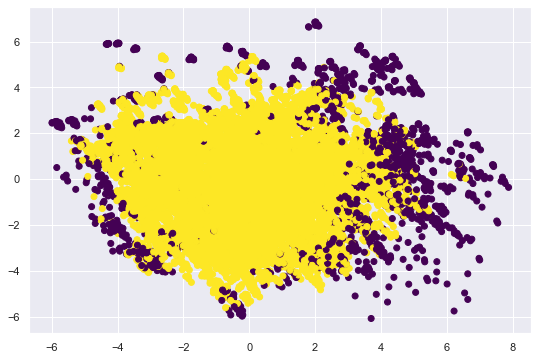

In [47]:
plt.scatter(data_pca[:,0], data_pca[:,1], c=iso_predictions_2, cmap='viridis')

After tuning hyperparameters we got even more outliers, so it didn't really help.

In [54]:
results, f1 = evaluate_metrics(target_2, iso_predictions_2)
print(f1) # weighted f1 score
results

0.9319949633232354


0         1
Precision  0.101303  0.989534
Recall     0.518182  0.908338
F1_score   0.169475  0.947199
F_beta     0.284242  0.923494

### Conclusion

* Among supervised models (not tuned), SVM with oversampling gave the best result.
* As for unsupervised methods,  OneClassSVM after tuning turned out to be the best one, but all of them performed worse than supervised models (even without oversampling).

It's hard to say what caused such poor results in case of unsupervised algorithms - maybe some different features should be created or other techniques should be used.